# Sklearn models try

In [1184]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from metrics import average_precision_score, ndcg_score
import warnings
warnings.filterwarnings('ignore')
def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

import hyperopt
from hyperopt import hp
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold

from IPython.display import HTML as html_print
from IPython.display import HTML
from IPython.display import display

In [1413]:
# extracting data
data = pd.read_csv('data/features-2.csv')


In [1419]:
data.describe()

,Unnamed: 0,venue_id,latitude,longitude,density,neighbors_entropy,competitiveness,area_popularity,transition_density,incoming_flow,transition quality,n_same_business_in_area,target_check_ins
count,277.00000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.00000,277.000000,277.0,277.000000
mean,138.00000,45750.075812,40.737317,-73.919080,84.368231,5.850152,-0.075076,1561.718412,301.205776,479.65343,19.815884,0.0,269.801444
std,80.10722,24741.965122,0.079282,0.135762,101.946214,2.079991,0.090120,2647.804810,511.992560,834.76944,30.484708,0.0,267.019269
min,0.00000,162.000000,40.516800,-74.233310,1.000000,0.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,0.0,6.000000
25%,69.00000,26240.000000,40.700645,-73.997420,14.000000,4.125843,-0.100000,52.000000,11.000000,13.00000,1.000000,0.0,110.000000
50%,138.00000,48149.000000,40.736797,-73.957750,27.000000,5.665379,-0.051282,234.000000,49.000000,55.00000,4.000000,0.0,194.000000
75%,207.00000,66822.000000,40.777530,-73.857170,141.000000,7.598930,-0.021739,1783.000000,347.000000,582.00000,30.000000,0.0,331.000000
max,276.00000,85297.000000,40.959766,-73.516380,396.000000,10.556083,0.000000,13152.000000,2651.000000,4209.00000,139.000000,0.0,2412.000000


In [1420]:
X = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow','transition quality']]
X2 = data[['density','neighbors_entropy']]
y = data['target_check_ins']
def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())
X = normalize(X)
y = normalize(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [1421]:
# sklearn grids
grid_SGD = {'alpha':hp.uniform('alpha', 0, 0.3),
            'penalty': hp.choice('penalty',['l2', 'l1', 'elasticnet'])}
grid_DecisionTreeRegressor = {
                              'random_state':hp.quniform('random_state', 1, 20, q=1),
                              'max_depth': hp.quniform('max_depth', 1, 30, q=1)
                                }
grid_Lasso = {  'alpha':hp.uniform('alpha', 0, 2),
                'random_state':hp.quniform('random_state', 1, 20, q=1),
                'max_iter': hp.quniform('max_iter', 1, 20000, q=1)}
                                

grid_Elastic = {'alpha':hp.uniform('alpha', 0, 2),
                'random_state':hp.quniform('random_state', 1, 20, q=1),
                'max_iter': hp.quniform('max_iter', 1, 20000, q=1)
                                }

grid_Ridge =  { 'alpha':hp.uniform('alpha', 0, 3),
                'random_state':hp.quniform('random_state', 1, 20, q=1),
                'solver':hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
                                }

grids = [grid_SGD,grid_DecisionTreeRegressor,grid_Lasso,grid_Elastic,grid_Ridge]

In [1422]:
#defining metric ndcg
def ndcg(y_real, y_pred, p=10):
    to_test = pd.DataFrame({'real':y_real, 'predicted':y_pred})
    to_test = to_test.sort_values(by = 'real', ascending=False)
    to_test['real_ratings'] = [abs(x) for x in range(-len(to_test),0)]
    to_test = to_test.sort_values(by = 'predicted', ascending=False)
    rr = list(to_test.head(p).real_ratings)
    dcg = 0
    idcg = 0
    for i in range(len(rr)):
        dcg+=rr[i]/np.log2(i+2)
        idcg+=(len(to_test)-i)/np.log2(i+2)
    return dcg/idcg

from sklearn.metrics import fbeta_score, make_scorer
ndcg_scorer = make_scorer(ndcg)

In [1423]:
class SGD_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = SGDRegressor(alpha = X['alpha'], penalty=X['penalty'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization
    
    
class DT_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = DecisionTreeRegressor(random_state=int(X['random_state']), max_depth = X['max_depth'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization

    
    
class Lasso_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = Lasso(alpha = X['alpha'], random_state=int(X['random_state']), max_iter=X['max_iter'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization



class Elastic_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = ElasticNet(alpha = X['alpha'], random_state=int(X['random_state']), max_iter=X['max_iter'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization
    
    
class Ridge_reg:

    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Calculate cross validation score (default is10-fold CV)
    def __call__(self, X, cv=10):
        # Make the SVM classifire with  the specific 'C' and 'degree'
        reg = Ridge(random_state=int(X['random_state']), solver = X['solver'], alpha = X['alpha'])
        # Compute the CV score
        accuracy = cross_val_score(reg, self.X, self.y, scoring=ndcg_scorer, cv=KFold(n_splits=cv, shuffle=False))
        accuracy = np.mean(accuracy)
        #print(accuracy, X)
        return 1. - accuracy    # for minimization
    
    
functions = [SGD_reg,DT_reg,Lasso_reg,Elastic_reg,Ridge_reg]

In [1424]:
# Objective function
f = SGD_reg(X_train, y_train)
trials = hyperopt.Trials()

# Run TPE
best = hyperopt.fmin(f, grid_SGD, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
print("best estimate parameters", best)

best estimate parameters {'alpha': 0.01775039141993587, 'penalty': 2}


In [1425]:
# Objective function
f = DT_reg(X_train, y_train)
trials = hyperopt.Trials()

# Run TPE
best = hyperopt.fmin(f, grid_DecisionTreeRegressor, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
print("best estimate parameters", best)

best estimate parameters {'max_depth': 5.0, 'random_state': 1.0}


In [1426]:
# Objective function
f = Elastic_reg(X_train, y_train)
trials = hyperopt.Trials()

# Run TPE
best = hyperopt.fmin(f, grid_Elastic, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
print("best estimate parameters", best)

best estimate parameters {'alpha': 0.019220580921034625, 'max_iter': 6599.0, 'random_state': 12.0}


In [1427]:
# Objective function
f = Lasso_reg(X_train, y_train)
trials = hyperopt.Trials()

# Run TPE
best = hyperopt.fmin(f, grid_Lasso, algo=hyperopt.tpe.suggest, max_evals=30, trials=trials, verbose=1)
print("best estimate parameters", best)

best estimate parameters {'alpha': 0.6361435046698776, 'max_iter': 531.0, 'random_state': 17.0}


In [1428]:
# Objective function
f = Ridge_reg(X_train, y_train)
trials = hyperopt.Trials()

# Run TPE
best = hyperopt.fmin(f, grid_Ridge, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
print("best estimate parameters", best)

best estimate parameters {'alpha': 0.1101702904487063, 'random_state': 14.0, 'solver': 6}


# With normalization

In [1477]:
X = data[['density','transition_density']]
X2 = data[['density','neighbors_entropy']]
y = data['target_check_ins']

X = normalize(X)
y = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [ ]:
for func, grid, reg in zip(functions, grids, regressors):
    # Objective function
    f = func(X_train, y_train)
    trials = hyperopt.Trials()
    # Run TPE
    best = hyperopt.fmin(f, grid, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
    print(func)
    print("best estimate parameters", best)

<class '__main__.SGD_reg'>
best estimate parameters {'alpha': 0.22982677546065627, 'penalty': 0}


In [1441]:
# tuned parametres 
accuracy_m = []
accuracy_s = []
accuracy_a = []
regg_n = ['SGDRegressor', 'DecisionTreeRegressor', 'ElasticNet', 'Lasso', 'Ridge']
regressors_norm = [
               SGDRegressor(alpha= 0.06209893459143488, penalty='elasticnet'), 
               DecisionTreeRegressor(max_depth= 5.0, random_state= 5),
               ElasticNet(alpha=  0.007273614678825778, max_iter =  19367, random_state = 3), 
               Lasso(alpha =  1.9084517496724411, max_iter = 17000, random_state =  12),
               Ridge(random_state =  20, solver = 'cholesky', alpha =  0.026141780377840013)
]
for regg in regressors: 
    accuracy = cross_val_score(regg, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True))
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    accuracy_m.append(accuracy_mean)
    accuracy_s.append(accuracy_std)
    accuracy_a.append(accuracy)
    print(regg)
    print(accuracy_mean)
    print(accuracy_std)

SGDRegressor(alpha=0.018071172859816687, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, penalty='elasticnet', power_t=0.25, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.7945986618826277
0.08384816608240049
DecisionTreeRegressor(criterion='mse', max_depth=3.0, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=14, splitter='best')
0.806704384115636
0.08618395917578066
ElasticNet(alpha=0.38779520909787646, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=1845, normalize=False, positive=False,
      precompute=False, random_state=14, selection='cyclic', tol=0.0001,
      warm_start=False)
0.6364940874152536
0.03220185994486173
Lasso(alph

In [1332]:
def highlight_max(s, col="orange"):
    '''
    Color the maximum value in column or row of the DataFrame into yellow.
    :input: serires object
    :return: colored object
    '''
    is_min = s == s.max()
    return ['background-color: {}'.format(col) if v else '' for v in is_min]
def highlight_min(s, col="yellow"):
    '''
    Color the maximum value in column or row of the DataFrame into yellow.
    :input: serires object
    :return: colored object
    '''
    is_min = s == s.min()
    return ['background-color: {}'.format(col) if v else '' for v in is_min]

In [1333]:
print(  )
display(html_print("<p style='font-weight: bold; color:black; font-size:200%; font-family:verdana;text-align:center;'> Ranking metrics NDCG@10 with Normalization</p>"))
print() 
    
with_norm = pd.DataFrame({'cross_val_ndcg_mean':accuracy_m, 'cross_val_ndcg_std':accuracy_s}, index = regg_n)
with_norm = with_norm.sort_values('cross_val_ndcg_mean', ascending = False).style.apply(lambda x: highlight_max(x, col="orange"), axis=0)

with_norm

,cross_val_ndcg_mean,cross_val_ndcg_std
Ridge,0.882092,0.0684436
Lasso,0.842411,0.0428809
DecisionTreeRegressor,0.840669,0.0645485
SGDRegressor,0.833449,0.0778142
ElasticNet,0.636494,0.0322019


In [1334]:
import plotly.plotly as py
import plotly.graph_objs as go

x = regg_n
y = accuracy_m
z = accuracy_s

datap = [
  go.Histogram(
    histfunc = "avg",
    y = y,
    x = x,
    name = "mean")
]

py.iplot(datap, filename='binning function')

# Without normalization

In [1442]:
X = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow','transition quality']]
X2 = data[['density','neighbors_entropy']]
y = data['target_check_ins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

for func, grid, reg in zip(functions, grids, regressors):
    # Objective function
    f = func(X_train, y_train)
    trials = hyperopt.Trials()
    # Run TPE
    best = hyperopt.fmin(f, grid, algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
    print(func)
    print("best estimate parameters", best)

<class '__main__.SGD_reg'>
best estimate parameters {'alpha': 0.18032667207782432, 'penalty': 2}
<class '__main__.DT_reg'>
best estimate parameters {'max_depth': 5.0, 'random_state': 14.0}
<class '__main__.Lasso_reg'>
best estimate parameters {'alpha': 0.009926311368368301, 'max_iter': 231.0, 'random_state': 17.0}
<class '__main__.Elastic_reg'>
best estimate parameters {'alpha': 0.0004957483170772159, 'max_iter': 5290.0, 'random_state': 16.0}
<class '__main__.Ridge_reg'>
best estimate parameters {'alpha': 0.8611630333205722, 'random_state': 20.0, 'solver': 4}


In [1475]:
# tuned parametres
accuracy_m_non = []
accuracy_s_non = []
regg_n = ['SGDRegressor', 'DecisionTreeRegressor', 'ElasticNet', 'Lasso', 'Ridge']
regressors = [
               SGDRegressor(alpha= 0.18032667207782432, penalty='elasticnet'), 
               DecisionTreeRegressor(max_depth= 5.0, random_state= 14),
               ElasticNet(alpha= 0.0004957483170772159, max_iter = 5300, random_state = 16), 
               Lasso(alpha =  0.009926311368368301, max_iter = 300, random_state =  17),
               Ridge(random_state =  8, solver = 'sparse_cg', alpha = 0.8611630333205722)
]
for regg in regressors: 
    accuracy = cross_val_score(regg, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True))
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    accuracy_m_non.append(accuracy_mean)
    accuracy_s_non.append(accuracy_std)
    print(regg)
    print(accuracy_mean)
    print(accuracy_std)

SGDRegressor(alpha=0.18032667207782432, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
0.4273184637833437
0.15897436797810838
DecisionTreeRegressor(criterion='mse', max_depth=5.0, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=14, splitter='best')
0.7131609883675558
0.07451700798356291
ElasticNet(alpha=0.0004957483170772159, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=5300, normalize=False, positive=False,
      precompute=False, random_state=16, selection='cyclic', tol=0.0001,
      warm_start=False)
0.849526282732952
0.034782313060034695
Lasso(al

In [1337]:
print(  )
display(html_print("<p style='font-weight: bold; color:black; font-size:200%; font-family:verdana;text-align:center;'> Ranking metrics NDCG@10 without Normalization</p>"))
print() 
    
with_norm = pd.DataFrame({'cross_val_ndcg_mean':accuracy_m_non, 'cross_val_ndcg_std':accuracy_s_non}, index = regg_n)
with_norm = with_norm.sort_values('cross_val_ndcg_mean', ascending = False).style.apply(lambda x: highlight_max(x, col="orange"), axis=0)

with_norm

,cross_val_ndcg_mean,cross_val_ndcg_std
Ridge,0.879006,0.0559716
ElasticNet,0.873422,0.0213508
Lasso,0.864594,0.0676393
DecisionTreeRegressor,0.84499,0.0490028
SGDRegressor,0.409987,0.214266


In [1338]:
import plotly.plotly as py
import plotly.graph_objs as go

x = regg_n
y = accuracy_m_non
z = accuracy_s_non

datap = [
  go.Histogram(
    histfunc = "avg",
    y = y,
    x = x,
    name = "mean")
]

py.iplot(datap, filename='binning function')

# Let's try XGBoost

In [1339]:
import xgboost as xgb
from xgboost import XGBRegressor
grid_GB = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
gb = XGBRegressor(**grid_GB)


gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)


data_dmatrix = xgb.DMatrix(X_train,y_train)
print(ndcg(y_real = y_test, y_pred = y_pred))

print(gb.feature_importances_)

0.8271076554929139
[0.2580463  0.1552795  0.20327498 0.14906833 0.11744777 0.11688311]


In [1340]:
# without normalization
X = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow']]
y = data['average_check_ins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
XGBRegressor = xgb.XGBRegressor(random_state=1, objective = 'reg:linear')
CV_SSS = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

xgb_param_grid = {
                  'max_depth': [x for x in range(2,10)],
                  'learning_rate': [x*0.001 for x in range(0,100)],
                  'n_estimators': [x*10 for x in range(5,15)],
                  'reg_alpha': [x*0.05 for x in range(3,15)],
                  'reg_lambda': [x*0.05 for x in range(3,14)],
                  'min_child_weight':[x for x in range(0,10)],
                  'subsample':[x*0.05 for x in range(2,10)],
                  'colsample_bytree':[x*0.05 for x in range(6,10)]
                 }

random_grid_XGB_CV = RandomizedSearchCV(XGBRegressor,
                                        xgb_param_grid,
                                        scoring = ndcg_scorer,
                                        cv = CV_SSS,
                                        n_iter = 400
                                        )
random_grid_XGB_CV.fit(X_train, y_train)
print(random_grid_XGB_CV.best_score_)
print(random_grid_XGB_CV.best_params_)


0.8496128210955888
{'subsample': 0.15000000000000002, 'reg_lambda': 0.65, 'reg_alpha': 0.55, 'n_estimators': 130, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.067, 'colsample_bytree': 0.45}


In [1353]:
XGB_Regressor = random_grid_XGB_CV.best_estimator_
features_importamce = [XGB_Regressor.feature_importances_]
scores = cross_val_score(XGB_Regressor, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True))
print('XGBoost score without norming', scores.mean(), scores.std())



rig = regressors[4]
scores = cross_val_score(rig, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True))
print('Ridge score without norming', scores.mean(), scores.std())
rig = regressors[4]
rig.fit(X_train, y_train)
features_importamce.append(rig.coef_)


XGBoost score without norming 0.8181142946796622 0.08256136666136932
Ridge score without norming 0.8582753071207518 0.06516180013901139


In [1345]:
accuracy_m_non.append(scores.mean())
accuracy_s_non.append(scores.std())
regg_n.append('XGBoost')

In [1347]:
# with normalization
X = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow']]
y = data['average_check_ins']

X = normalize(X)
y = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
XGBRegressor2 = xgb.XGBRegressor(random_state=1, objective = 'reg:linear')
CV_SSS = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

xgb_param_grid = {
                  'max_depth': [x for x in range(2,10)],
                  'learning_rate': [x*0.001 for x in range(0,100)],
                  'n_estimators': [x*10 for x in range(5,15)],
                  'reg_alpha': [x*0.05 for x in range(3,15)],
                  'reg_lambda': [x*0.05 for x in range(3,14)],
                  'min_child_weight':[x for x in range(0,10)],
                  'subsample':[x*0.05 for x in range(2,10)],
                  'colsample_bytree':[x*0.05 for x in range(6,10)]
                 }

random_grid_XGB_CV2 = RandomizedSearchCV(XGBRegressor2,
                                        xgb_param_grid,
                                        scoring = ndcg_scorer,
                                        cv = CV_SSS,
                                        n_iter = 400
                                        )
random_grid_XGB_CV2.fit(X_train, y_train)
print(random_grid_XGB_CV2.best_score_)
print(random_grid_XGB_CV2.best_params_)

0.8516188273744274
{'subsample': 0.25, 'reg_lambda': 0.30000000000000004, 'reg_alpha': 0.25, 'n_estimators': 60, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.019, 'colsample_bytree': 0.4}


In [1349]:
XGB_Regressor2 = random_grid_XGB_CV2.best_estimator_
features_importamce2 = [XGB_Regressor2.feature_importances_]
scores = cross_val_score(XGB_Regressor2, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True))
print('XGBoost score with norming', scores.mean(), scores.std())


rig = regressors_norm[4]
rig.fit(X_train, y_train)
scores = cross_val_score(rig, X_train, y_train, scoring=ndcg_scorer, cv=KFold(n_splits=5, shuffle=True))
print('Ridge score with norming', scores.mean(), scores.std())
features_importamce2.append(rig.coef_)

XGBoost score with norming 0.8453343697276425 0.046543508900792833
Ridge score with norming 0.8774614861460337 0.030579698823929705


In [1350]:
accuracy_m.append(scores.mean())
accuracy_s.append(scores.std())

In [1354]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 6
x = ['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow']

# Create traces
trace1 = go.Scatter(
    x = x,
    y = features_importamce[0],
    mode = 'lines+markers',
    name = 'XGBoost without norming'
)
trace2 = go.Scatter(
    x = x,
    y = features_importamce[1],
    mode = 'lines+markers',
    name = 'Ridge without norming'
)
trace3 = go.Scatter(
    x = x,
    y = features_importamce2[0],
    mode = 'lines+markers',
    name = 'XGBoost with norming'
)
trace4 = go.Scatter(
    x = x,
    y = features_importamce2[1],
    mode = 'lines+markers',
    name = 'Ridge with norming'
)
dataq = [trace1, trace2, trace3, trace4]

# Edit the layout
layout = dict(title = 'Features importance for regressors',
              xaxis = dict(title = 'features'),
              yaxis = dict(title = 'coefs'),
              )
fig = dict(data=dataq, layout=layout)
py.iplot(fig, filename='line-mode')

# Baseline

In [1370]:
import numpy as np
import pandas as pd

X = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow']]
y = data['average_check_ins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

def baseline_model(y_test):
    return np.random.choice(len(y_test), len(y_test), replace=False)
scores = []
for i in range(10):
    preds = baseline_model(X_test)
    scores.append(ndcg(y_real=y_test,y_pred=preds))




In [1356]:
accuracy_m.append(np.array(scores).mean())
accuracy_s.append(np.array(scores).std())
regg_n.append('Baseline')

accuracy_m_non.append(np.array(scores).mean())
accuracy_s_non.append(np.array(scores).std())

# Plotting all the stuff

In [1371]:
import plotly.plotly as py
import plotly.graph_objs as go

x = regg_n
y = accuracy_m
z = accuracy_s

datap = [
  go.Histogram(
    histfunc = "avg",
    y = y,
    x = x)
]

layout = dict(title = 'Comparing performance of regressors with normalization',
              xaxis = dict(title = 'Alghorithms'),
              yaxis = dict(title = 'NDCG'),
              )
fig = dict(data=datap, layout=layout)

py.iplot(fig, filename='histogram')

In [1372]:
import plotly.plotly as py
import plotly.graph_objs as go

x = regg_n
y = accuracy_m_non
z = accuracy_s_non

datap = [
  go.Histogram(
    histfunc = "avg",
    y = y,
    x = x,
    name = "mean")
]
layout = dict(title = 'Comparing performance of regressors without normalization',
              xaxis = dict(title = 'Alghorithms'),
              yaxis = dict(title = 'NDCG'),
              )
fig = dict(data=datap, layout=layout)

py.iplot(fig, filename='histogram')

# Ploting the heatmap for correlations

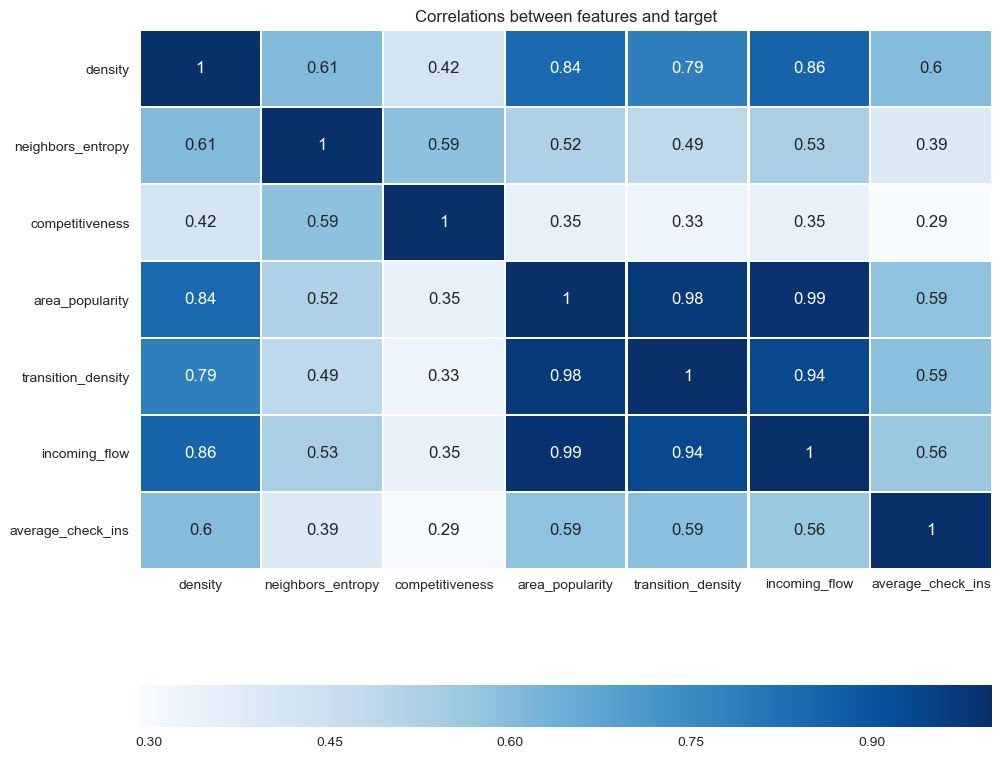

In [1411]:
import numpy as np
np.random.seed(0)
import seaborn as sns
plt.rcParams['figure.figsize'] = [11,10]
corr = data[['density','neighbors_entropy','competitiveness','area_popularity','transition_density','incoming_flow', 'average_check_ins']].corr()
sns.heatmap(corr, annot=True, linewidths=1, cbar_kws={"orientation": "horizontal"}, cmap="Blues")
plt.title('Correlations between features and target')
plt.show()

[]

In [816]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

Number of variables,11
Number of observations,277
Total Missing (%),0.0%
Total size in memory,26.0 KiB
Average record size in memory,96.0 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,2
